# Wrangling

In [2]:
#Loading all necessary libraries.
library(dplyr)
library(ggplot2)
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
#Reading the CSV file into Jupyter and previewing the first 6 rows.
vancouver_crime_data <- read.csv("crimedata_csv_AllNeighbourhoods_AllYears.csv")
head(vancouver_crime_data)

#Printing total number of crimes that have happened in Vancouver.
cat("Number of Crimes: ", nrow(vancouver_crime_data))

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Other Theft,2019,3,14,10,34,47XX OAK ST,South Cambie,490706.9,5454474
2,Other Theft,2005,8,1,0,0,47XX OAK ST,South Cambie,490706.9,5454474
3,Other Theft,2012,12,6,9,30,47XX OAK ST,South Cambie,490706.9,5454474
4,Other Theft,2004,1,25,17,0,47XX OAK ST,South Cambie,490710.6,5454535
5,Other Theft,2020,9,22,11,36,47XX OSLER ST,Shaughnessy,490528.5,5454450
6,Other Theft,2003,8,18,7,30,47XX OSLER ST,Shaughnessy,490529.8,5454502


Number of Crimes:  853296

In [4]:
#Selecting only theft-related crimes and mutating hours into "day" and "night". Crimes that happened
#between 6 am and 18 pm are considered "day" and the rest are considered "night". Lastly, only columns
# of interest are selected (hour, da-night, type). A few others are selected for graphing purposes.
vancouver_thefts <- vancouver_crime_data %>%
    filter(TYPE == "Other Theft" | TYPE == "Theft from Vehicle" | TYPE == "Theft of Vehicle" | TYPE == "Theft of Bicycle") %>%
    mutate(DAY_NIGHT = ifelse(HOUR >= 6 & HOUR < 18, "DAY", "NIGHT")) %>%
    select(TYPE, YEAR, HOUR, DAY_NIGHT, NEIGHBOURHOOD)
head(vancouver_thefts)

#Obtaining the total number of crimes per type of theft-related crime.
theft_counts <- vancouver_thefts %>%
    group_by(TYPE) %>%
    summarise(COUNT = n())
theft_counts

,TYPE,YEAR,HOUR,DAY_NIGHT,NEIGHBOURHOOD
,<chr>,<int>,<int>,<chr>,<chr>
1,Other Theft,2019,10,DAY,South Cambie
2,Other Theft,2005,0,NIGHT,South Cambie
3,Other Theft,2012,9,DAY,South Cambie
4,Other Theft,2004,17,DAY,South Cambie
5,Other Theft,2020,11,DAY,Shaughnessy
6,Other Theft,2003,7,DAY,Shaughnessy


TYPE,COUNT
<chr>,<int>
Other Theft,210540
Theft from Vehicle,237891
Theft of Bicycle,36403
Theft of Vehicle,44404


`summarise()` has grouped output by 'TYPE'. You can override using the
`.groups` argument.


TYPE,DAY_NIGHT,COUNT,PROP
<chr>,<chr>,<int>,<dbl>
Other Theft,DAY,132566,0.6296476
Other Theft,NIGHT,77974,0.3703524
Theft from Vehicle,DAY,102276,0.4299280
Theft from Vehicle,NIGHT,135615,0.5700720
Theft of Bicycle,DAY,19634,0.5393512
Theft of Bicycle,NIGHT,16769,0.4606488
Theft of Vehicle,DAY,17364,0.3910459
Theft of Vehicle,NIGHT,27040,0.6089541


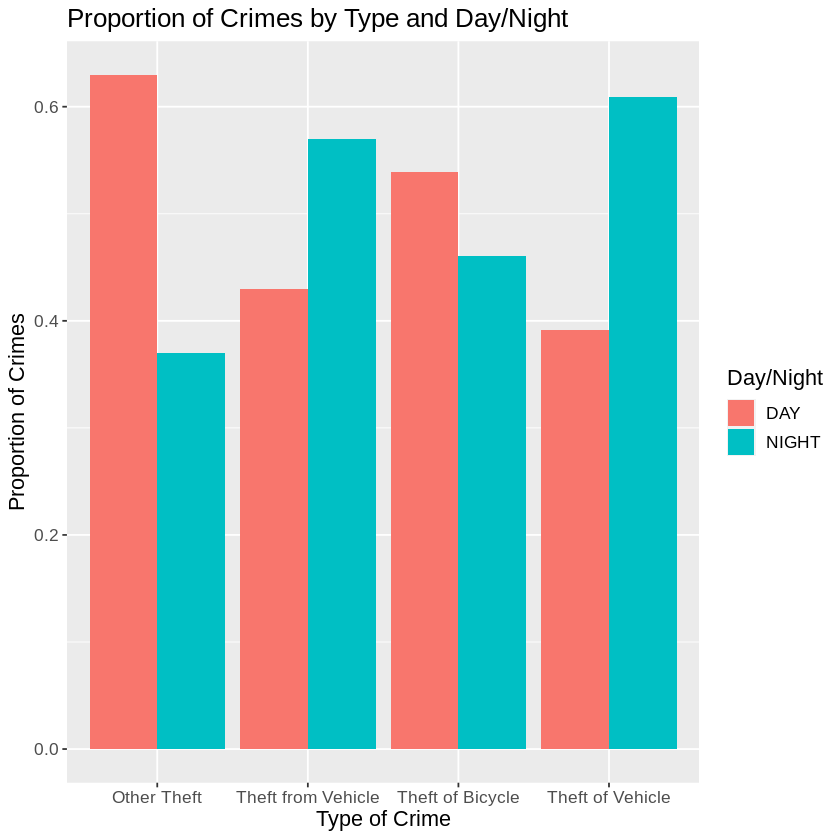

In [5]:
#Obtaining the total number of crimes per type of theft-related crime and whether it is day or night.
# Also obtaining its proportion.
theft_counts_by_type <- vancouver_thefts %>%
  group_by(TYPE, DAY_NIGHT) %>%
  summarise(COUNT = n()) %>%
  mutate(PROP = COUNT / sum(COUNT))
theft_counts_by_type

# Graphing a histogram plot of the proportion of crimes based on theft-type and whether it is day or night.
theft_counts_by_type_plot <- theft_counts_by_type |>
  ggplot(aes(x=TYPE, y=PROP, fill=DAY_NIGHT)) +
  geom_bar(stat="identity", position="dodge") +
  labs(x="Type of Crime", y="Proportion of Crimes", fill="Day/Night") +
  ggtitle("Proportion of Crimes by Type and Day/Night") +
  theme(text = element_text(size=13)) 
theft_counts_by_type_plot

HOUR,COUNT
<int>,<int>
0,120522
1,21029
2,16726
3,14227
4,12763
5,12129
6,12865
7,17271
8,25721


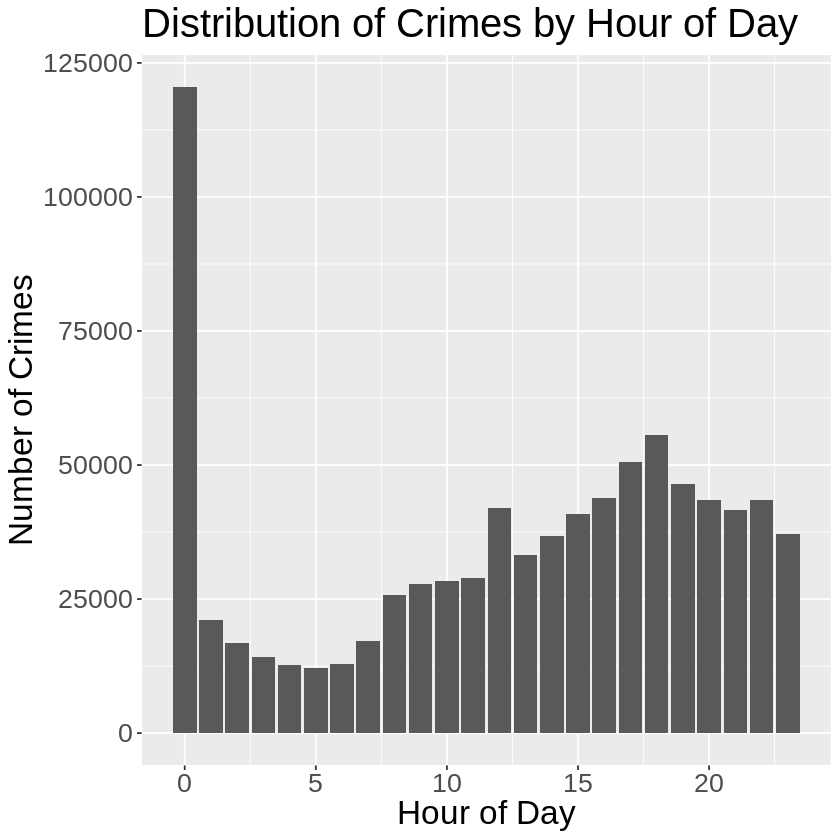

In [10]:
#Obtaining number of crimes that occur per hour of the day.
theft_counts_hour <- vancouver_crime_data %>%
  group_by(HOUR) %>%
  summarise(COUNT = n())
theft_counts_hour

#Graphing a histogram plot of the number of crimes that happen per each hour of the day.
theft_counts_hour_plot <- ggplot(theft_counts_hour, aes(x=HOUR, y=COUNT)) +
  geom_bar(stat="identity") +
  labs(x="Hour of Day", y="Number of Crimes") +
  ggtitle("Distribution of Crimes by Hour of Day") +
  theme(text = element_text(size=20))
  
theft_counts_hour_plot

DAY_NIGHT,COUNT,PROP
<chr>,<int>,<dbl>
DAY,388337,0.4551023
NIGHT,464959,0.5448977


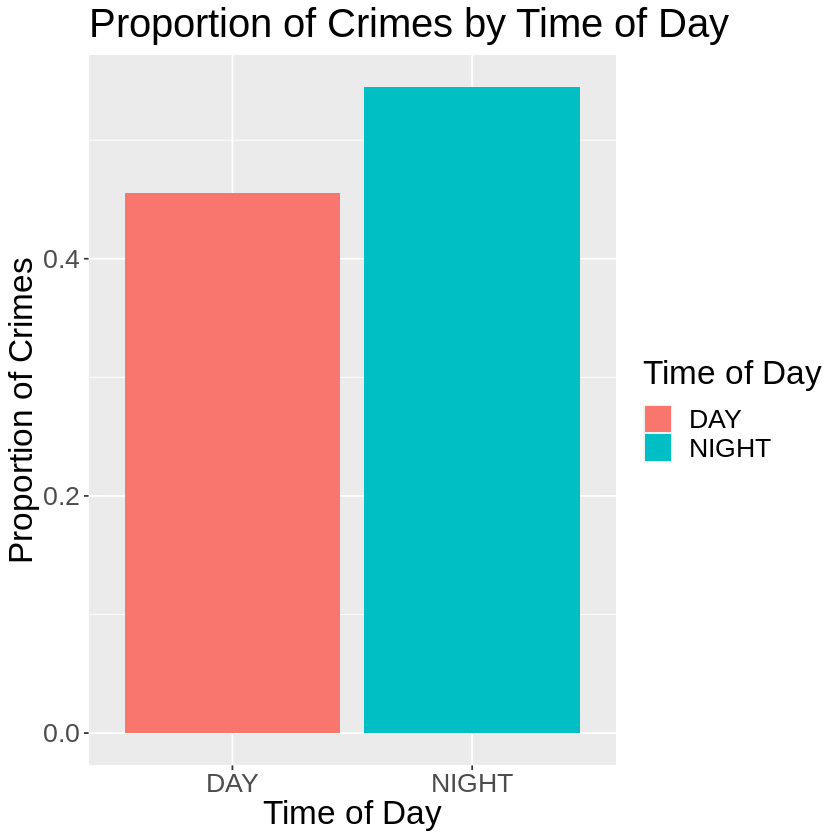

In [11]:
#Obtaining overall number of crimes that happen during the day vs night and their proportions.
theft_counts_by_day_night <- vancouver_crime_data %>%
  mutate(DAY_NIGHT = ifelse(HOUR >= 6 & HOUR < 18, "DAY", "NIGHT")) %>%
  group_by(DAY_NIGHT) %>%
  summarise(COUNT = n()) %>%
  mutate(PROP = COUNT / sum(COUNT))
theft_counts_by_day_night

#Graphing a bar plot of the proportion of crimes that happen in the day vs night.
theft_counts_by_day_night_plot <- 
  ggplot(theft_counts_by_day_night, aes(x=DAY_NIGHT, y=PROP, fill=DAY_NIGHT)) +
  geom_bar(stat="identity") +
  labs(x = "Time of Day", y= "Proportion of Crimes", fill="Time of Day") +
  ggtitle("Proportion of Crimes by Time of Day") +
  theme(text = element_text(size=20))
theft_counts_by_day_night_plot

In [12]:
sample1 <- vancouver_thefts |>
  rep_sample_n(size = 100, reps = 1, replace = FALSE) 

head(sample1)

replicate,TYPE,YEAR,HOUR,DAY_NIGHT,NEIGHBOURHOOD
<int>,<chr>,<int>,<int>,<chr>,<chr>
1,Theft of Bicycle,2021,19,NIGHT,Riley Park
1,Theft from Vehicle,2017,18,NIGHT,Oakridge
1,Theft of Vehicle,2017,19,NIGHT,Killarney
1,Theft from Vehicle,2018,19,NIGHT,Central Business District
1,Theft from Vehicle,2015,23,NIGHT,Mount Pleasant
1,Theft from Vehicle,2003,17,DAY,Central Business District


HOUR,COUNT
<int>,<int>
0,5
1,2
2,1
3,2
4,1
5,2
7,3
8,3
9,3


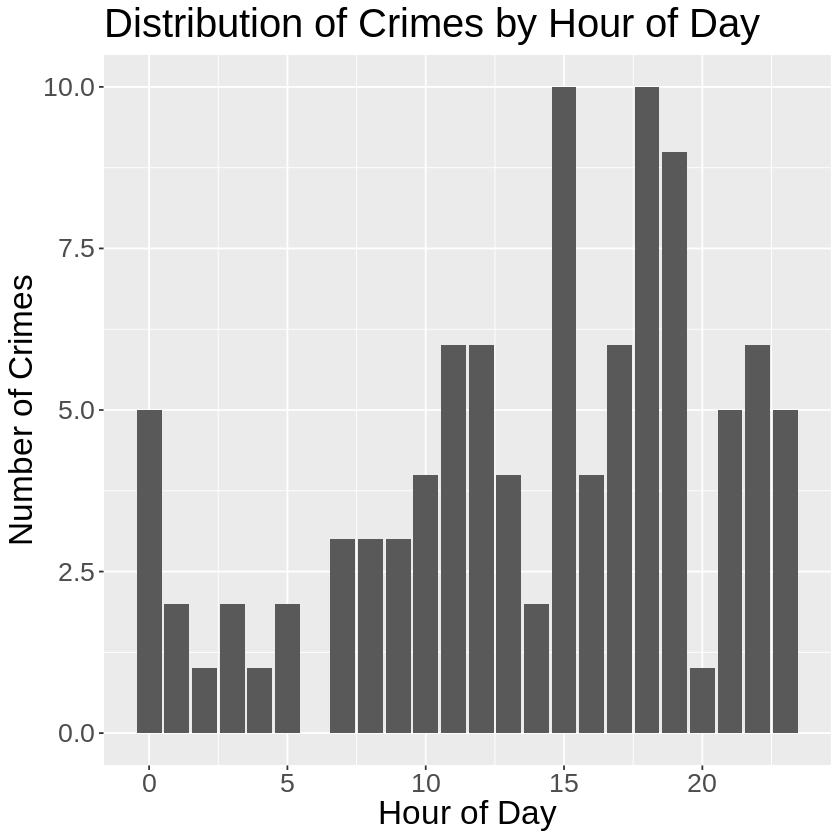

In [13]:
sample1_counts_hour <- sample1 %>%
  group_by(HOUR) %>%
  summarise(COUNT = n())
sample1_counts_hour

sample1_dist_plot <- ggplot(sample1_counts_hour, aes(x=HOUR, y=COUNT)) +
  geom_bar(stat="identity") +
  labs(x="Hour of Day", y="Number of Crimes") +
  ggtitle("Distribution of Crimes by Hour of Day") +
  theme(text = element_text(size=20))
sample1_dist_plot

DAY_NIGHT,COUNT,PROP
<chr>,<int>,<dbl>
DAY,51,0.51
NIGHT,49,0.49


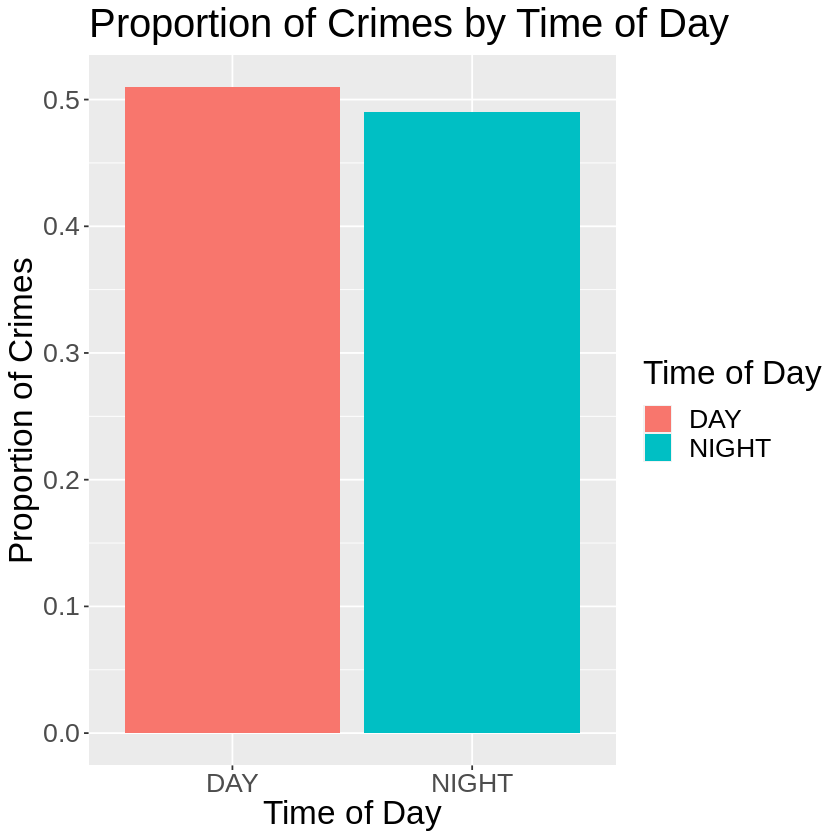

In [14]:
sample1_counts_by_day_night <- sample1 %>%
  mutate(DAY_NIGHT = ifelse(HOUR >= 6 & HOUR < 18, "DAY", "NIGHT")) %>%
  group_by(DAY_NIGHT) %>%
  summarise(COUNT = n()) %>%
  mutate(PROP = COUNT / sum(COUNT))
sample1_counts_by_day_night

sample1_counts_by_day_night_plot <- 
  ggplot(sample1_counts_by_day_night, aes(x=DAY_NIGHT, y=PROP, fill=DAY_NIGHT)) +
  geom_bar(stat="identity") +
  labs(x = "Time of Day", y= "Proportion of Crimes", fill="Time of Day") +
  ggtitle("Proportion of Crimes by Time of Day") +
  theme(text = element_text(size=20))
sample1_counts_by_day_night_plot

In [15]:
sample1_bootstarp <- sample1 |>
  rep_sample_n(size=100, reps=2000, replace=TRUE)

head(sample1_bootstarp)

replicate,TYPE,YEAR,HOUR,DAY_NIGHT,NEIGHBOURHOOD
<int>,<chr>,<int>,<int>,<chr>,<chr>
1,Other Theft,2014,18,NIGHT,Kitsilano
1,Other Theft,2017,4,NIGHT,Fairview
1,Theft from Vehicle,2011,15,DAY,Sunset
1,Theft from Vehicle,2003,17,DAY,Central Business District
1,Other Theft,2012,11,DAY,Central Business District
1,Theft of Vehicle,2017,19,NIGHT,Killarney


HOUR,COUNT
<int>,<int>
0,10009
1,3945
2,1992
3,3976
4,1992
5,3974
7,6041
8,5896
9,6033


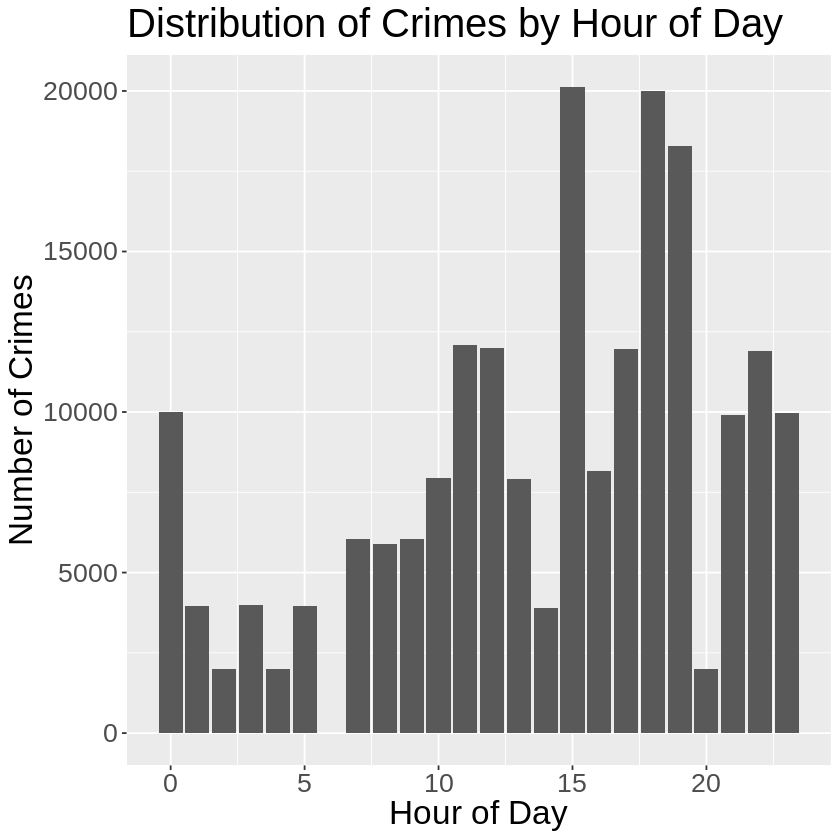

In [16]:
sample1_bs_counts_hour <- sample1_bootstarp %>%
  group_by(HOUR) %>%
  summarise(COUNT = n())
sample1_bs_counts_hour

sample1_bs_counts_hour_plot <- ggplot(sample1_bs_counts_hour, aes(x=HOUR, y=COUNT)) +
  geom_bar(stat="identity") +
  labs(x="Hour of Day", y="Number of Crimes") +
  ggtitle("Distribution of Crimes by Hour of Day") +
  theme(text = element_text(size=20))
sample1_bs_counts_hour_plot

DAY_NIGHT,COUNT,PROP
<chr>,<int>,<dbl>
DAY,102071,0.510355
NIGHT,97929,0.489645


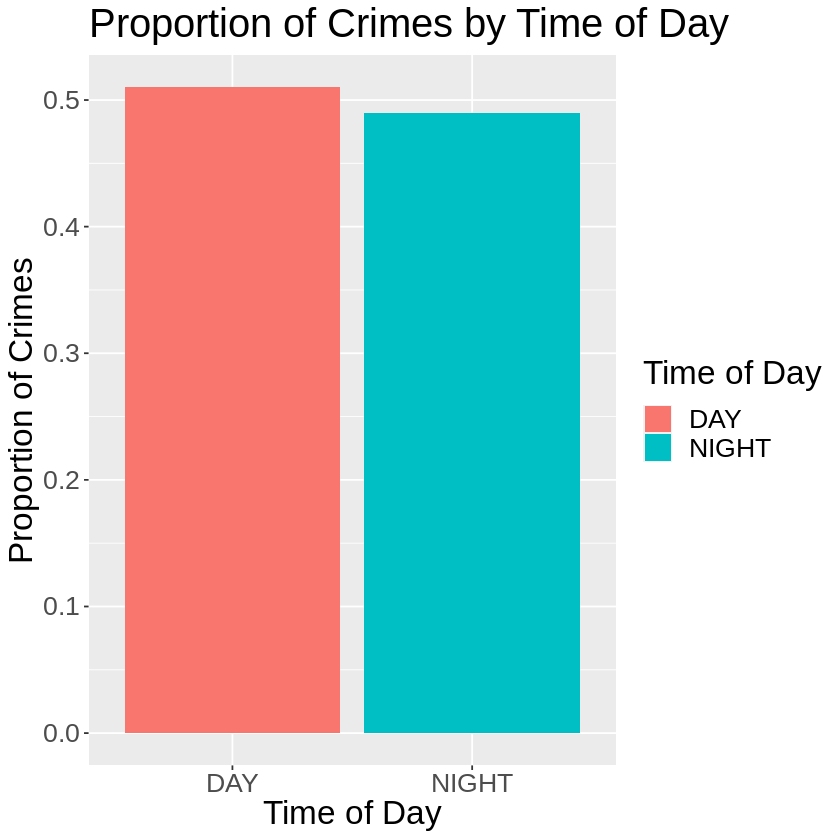

In [17]:
sample1_bs_counts_by_day_night <- sample1_bootstarp %>%
  mutate(DAY_NIGHT = ifelse(HOUR >= 6 & HOUR < 18, "DAY", "NIGHT")) %>%
  group_by(DAY_NIGHT) %>%
  summarise(COUNT = n()) %>%
  mutate(PROP = COUNT / sum(COUNT))
sample1_bs_counts_by_day_night

sample1_bs_counts_by_day_night_plot <- 
  ggplot(sample1_bs_counts_by_day_night, aes(x=DAY_NIGHT, y=PROP, fill=DAY_NIGHT)) +
  geom_bar(stat="identity") +
  labs(x = "Time of Day", y= "Proportion of Crimes", fill="Time of Day") +
  ggtitle("Proportion of Crimes by Time of Day") +
  theme(text = element_text(size=20))
sample1_bs_counts_by_day_night_plot

In [33]:
thefts_summary <- 
     vancouver_thefts %>% 
     group_by(DAY_NIGHT) %>% 
     summarise(n =  n(),
               prop = n/nrow(vancouver_thefts),              
               se = sqrt(prop * (1-prop)/n()),
               lower_ci = qnorm(0.025, prop, se),
               upper_ci = qnorm(0.975, prop, se)) %>% 
     mutate(DAY_NIGHT = fct_reorder(DAY_NIGHT, prop, .desc = TRUE))

head(thefts_summary)

DAY_NIGHT,n,prop,se,lower_ci,upper_ci
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
DAY,271840,0.5136441,0.0009586312,0.5117653,0.5155230
NIGHT,257398,0.4863559,0.0009851575,0.4844250,0.4882867


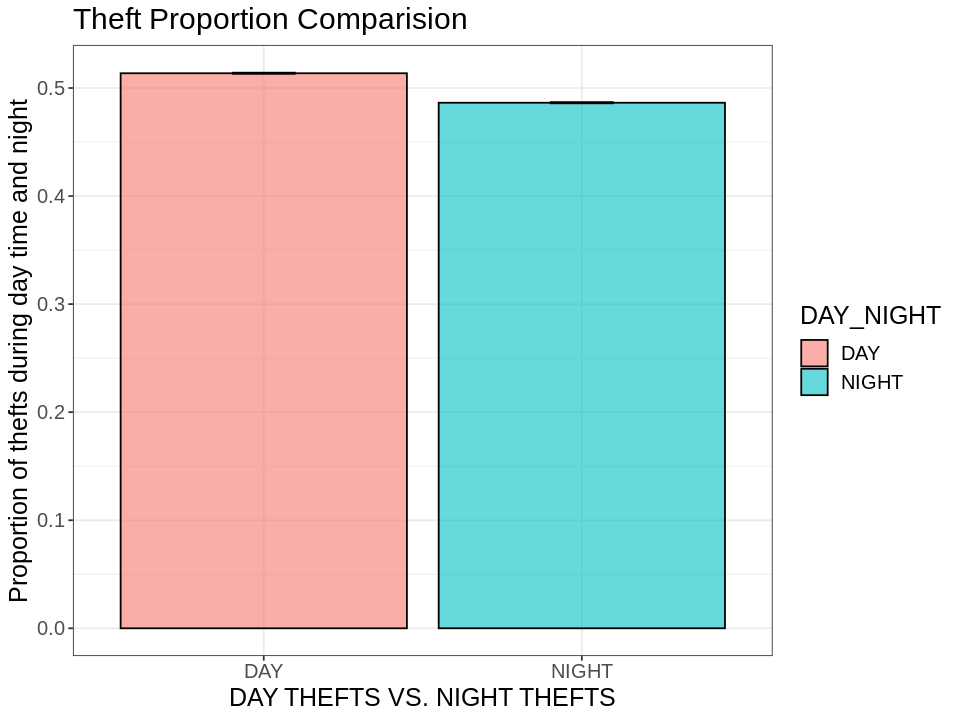

In [32]:
options(repr.plot.width = 8, repr.plot.height = 6)

thefts_ci_plot <- 
    thefts_summary %>% 
    ggplot(aes(x = DAY_NIGHT, y = prop, fill= DAY_NIGHT)) +
      geom_bar(stat = "identity", 
               colour="black",
               alpha = .6) +
      geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci),
                    size = 0.5, color = "black", width=.2) +
      theme_bw() +
      xlab("DAY THEFTS VS. NIGHT THEFTS") +
      ylab("Proportion of thefts during day time and night") +
      theme(text = element_text(size = 15)) + 
      ggtitle("Theft Proportion Comparision")

thefts_ci_plot